In [21]:
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display, HTML
display(HTML("<style>.output_scroll { max-height: none !important; }</style>"))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from scipy import signal

#Loading Dataset
df = pd.read_csv('./medical_time_series .csv')
#Check data types and size of df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Day      731 non-null    int64  
 1   Revenue  731 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 11.6 KB


731 days or rows indicates there's two years of data and a leap year is included; creating a start date of 01-01-2019 as this start date will include a leap year (2020). 

**Part I**

**A.1. Summarize one research question that is relevant to a real-world organizational situation captured in the selected data set and that you will answer using time series modeling techniques.** 
Using time series techniques, can we forecast the revenue for the WGU hospital in the next quarter (three months)? 

**A.2. Define the objectives or goals of the data analysis. Ensure your objectives or goals are reasonable within the scope of the scenario and are represented in the available data.**
his project aims to provide a model of the forecasted revenue of the next quarter (90 days) for the WGU hospital using the time series modeling technique ARIMA. The ARIMA model will be used on a training dataset before forecasting on a 20% test dataset of the WGU hospital data provided.  

**Part II**
  
**B. Summarize the assumptions of a time series model including stationarity and autocorrelated data.**
Assumptions of a times series model are as follows: 

- No trends or seasonality are found in the dataset 
- There are no outliers in the dataset 
- There is only one variable being modeled and tested (univariate) 
- Future data is forecasted based on prior data behavior.  

Seasonality is when a repeating pattern is seen within the data. Repeated number of sales seen year after year during the same month would mean the data has seasonality or a trend. The data must show no trends or seasonality to complete ARIMA time series modeling. The data must be differenced or shifted to eliminate the trends before moving forward with ARIMA modeling with stationary data (Sewell 2024).  

No outliers must be in the dataset, messing with the mean and standard deviation of the data. No points should be found very high or low from the general area where the other data points are located. If outliers are present, it will lower the moving average and decrease our ability to forecast the data correctly. 

Univariate testing is being completed, which is another assumption. This goes for any good research project, as testing more than one variable could lead to incorrect forecasts on the dataset. One variable can only be forecasted at a time. For this project, we forecast the revenue for the next quarter (90 days).  

The only way to forecast a company's earnings is to see the general behavior of previous months/years of revenue. If the company is decreasing its revenue yearly, then the forecast would indicate a downward trend, which would be the opposite for a company with yearly gains in revenue.

**Part III**

**C.1. Provide a line graph visualizing the realization of the time series.**
See visualization below the time-step formatting code.

**C.2. Describe the time step formatting of the realization, including any gaps in measurement and the length of the sequence.**
The dataset had only two columns: day and revenue. The day column was numbered 1 – 731 to indicate the days for two years of WGU hospital revenue. The revenue column was how much money, in millions, the hospital gained or lost each day of operation. The date column was a significant issue as it does not provide specifics about the actual dates of a year, for example, 02-29-2022. Therefore, we changed the day column to give an exact date for that day starting with 2019-01-01. Since there are 731 days in this dataset, one of the two years is a leap year with one more additional day. A leap year occurs every four years, so starting on 2019-01-01, this would include a leap year (2020) in the dataset. To change this issue, we added a column for the date using .to_datetime, and input the start date 2019-01-01. This added a new column for the date, so we needed to remove the Day column and reorganize the order of columns. As seen in the images below, we used .drop and .set_index to restructure this dataset. 

In [22]:
#Create a actual start date
start_date = pd.to_datetime('2019-01-01')
df.head()

,Day,Revenue
0,1,0.000000
1,2,-0.292356
2,3,-0.327772
3,4,-0.339987
4,5,-0.124888


In [24]:
#Convert the 'Day' column to a datetime column
df['Date'] = start_date + pd.to_timedelta(df['Day'] - 1, unit='D')

In [26]:
df.head()

,Day,Revenue,Date
0,1,0.000000,2019-01-01
1,2,-0.292356,2019-01-02
2,3,-0.327772,2019-01-03
3,4,-0.339987,2019-01-04
4,5,-0.124888,2019-01-05


In [28]:
#Rename the columns: 'Day' to 'Date' and 'Revenue' (no change)
df = df.rename(columns={'Day': 'Old_Day', 'Revenue': 'Revenue'})  #Keeping old Day for reference

#Dropping the old 'Day' column
if 'Old_Day' in df.columns:
    df.drop(columns=['Old_Day'], inplace=True)

#Set the 'Date' column as the index
if 'Date' in df.columns:
    df.set_index('Date', inplace=True)

df.head()

,Revenue
Date,
2019-01-01,0.000000
2019-01-02,-0.292356
2019-01-03,-0.327772
2019-01-04,-0.339987
2019-01-05,-0.124888


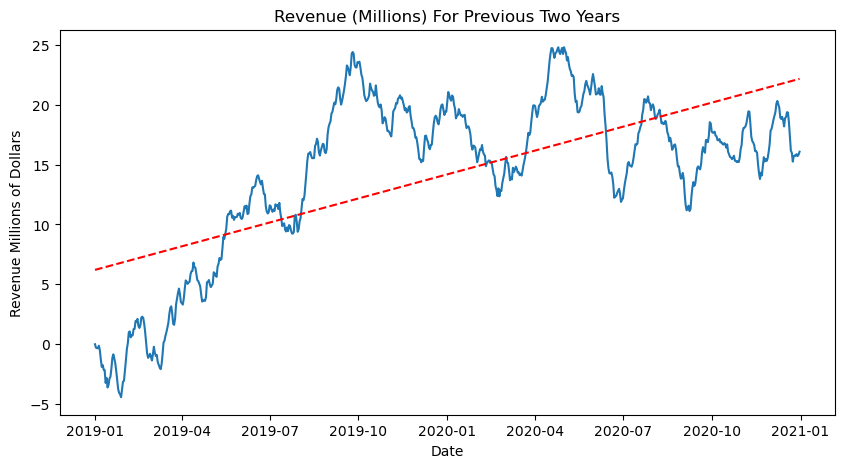

In [30]:
plt.figure(figsize=(10,5))
plt.plot(df.Revenue)

#trend line
x = mdates.date2num(df.index)
y = df.Revenue
z = np.polyfit(x, y, 1)
p = np.poly1d(z)

#Plot trendline
plt.plot(x, p(x), "r--")

plt.title('Revenue (Millions) For Previous Two Years')
plt.xlabel('Date')
plt.ylabel('Revenue Millions of Dollars')
plt.show()

In [32]:
#Export cleaned data
pd.DataFrame(df).to_csv("D213_T1_cleandf_JHOSEY.csv")

**C.3. Evaluate the stationarity of the time series.**

Stationarity means that the data will not have a trend or seasonality. From the screenshot in C1, the data is not stationary, as the trend line (red dashed line) has an upward trend. The dataset needs to be differenced or shifted to become stationary. In addition, the Augmented Dickey-Fuller (ADF) test was used to evaluate the stationarity of the dataset. The results of the first ADF test indicate that the p-value is 0.199, which is significant and tells us that the data is not stationary.  

In [34]:
#seeing initial stats prior to differencing
result = adfuller(df['Revenue'])
print("Test Statistics: ", result[0])
print("p-value: ", result[1])
print("Critical Values: ",result[4])

Test Statistics:  -2.2183190476089467
p-value:  0.19966400615064306
Critical Values:  {'1%': -3.4393520240470554, '5%': -2.8655128165959236, '10%': -2.5688855736949163}


In [36]:
#differencing to make time series stationary
df_stationary = df.diff().dropna()
df_stationary.head()

,Revenue
Date,
2019-01-02,-0.292356
2019-01-03,-0.035416
2019-01-04,-0.012215
2019-01-05,0.215100
2019-01-06,-0.366702


In [38]:
#Test if data is stationary
result = adfuller(df_stationary['Revenue'])
print("Test Statistics: ", result[0])
print("p-value: ", result[1])
print("Critical Values: ",result[4])
if result[1] <= 0.05: #Compare result against threshold
    print("Reject null hypothesis, this time series data is stationary.")
else:
    print("Accept null hypothesis, this time series data is non-stationary!")

Test Statistics:  -17.374772303557066
p-value:  5.113206978840171e-30
Critical Values:  {'1%': -3.4393520240470554, '5%': -2.8655128165959236, '10%': -2.5688855736949163}
Reject null hypothesis, this time series data is stationary.


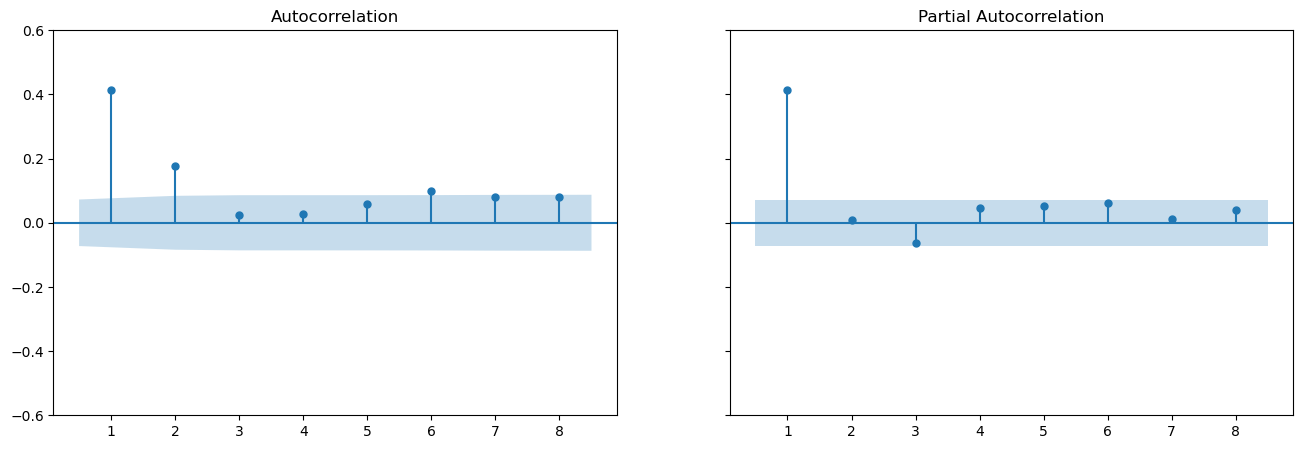

In [40]:
#Plot Autocorrelation and Partial Autocorrelation in one figure, sharing a y axis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[16,5], sharey=True)

plot_acf(df_stationary, lags=8, zero=False, ax=ax1)
plot_pacf(df_stationary, lags=8, zero=False,ax=ax2)

plt.ylim(-0.6, 0.6);

**C.4.  Explain the steps you used to prepare the data for analysis, including the training and test set split.**
Four significant steps must be taken before fitting the model and analyzing the results. Firstly, the 'day' column must be changed to the actual date. See C2 above for the code used. Secondly, the Date column then needs to become the index of the dataset. Again, see part C2 above for the code that transforms the date column. Thirdly, the Revenue data is not stationary, and we need to remove the trends/seasonality from the data before making the ARIMA model. The steps taken will be explained below. Fourthly, the data must be split into training and testing datasets before fitting them to an ARIMA model and using them to help answer the research question. The steps taken will be explained below.   

Our third step in preparing the dataset was eliminating stationarity in the Revenue data. We must decide whether to make a difference or shift the data to do this. The augmented Dicky Fuller (ADF) test indicated the p-value was 0.19, which is significant, as the dataset is not stationary. I chose to difference the data, using .diff().dropna(), and printed another ADF test.  Results returned with 0.000000000000000000000000000005 p-values, indicating that it is well below the 0.05 threshold and the data is now stationary.

The fourth step in preparing the dataset was to separate the dataset into training and testing files to be used when forecasting the next quarter of revenue for the WGU hospital. An 80-20 split was used for this project (see the code used below).

In [42]:
#Split data into a training set and a test set
train, test = train_test_split(df_stationary, test_size=0.2, shuffle=False, random_state=369)
train

,Revenue
Date,
2019-01-02,-0.292356
2019-01-03,-0.035416
2019-01-04,-0.012215
2019-01-05,0.215100
2019-01-06,-0.366702
...,...
2020-08-03,-0.694370
2020-08-04,-0.282765
2020-08-05,0.104732


In [44]:
test

,Revenue
Date,
2020-08-08,0.263991
2020-08-09,-0.588690
2020-08-10,-0.550427
2020-08-11,0.081477
2020-08-12,-0.146587
...,...
2020-12-27,-0.032693
2020-12-28,0.143766
2020-12-29,-0.156834


In [46]:
#Saving training and testing df's to CSV and stationary data
train.to_csv('D213_Task1_train_clean_JHOSEY.csv')
test.to_csv('D213_Task1_test_clean_JHOSEY.csv')
df_stationary.to_csv('df_stationary.csv')

**C.5.  Provide a copy of the cleaned data set.**

See files attached in task submission.

**Part IV: Model Identification and Analysis** 

**D.1. Report the annotated findings with visualizations of your data analysis, including the following elements:**
**- the presence or lack of a seasonal component**
The revenue displays fluctuations over the six months. Peaks and troughs occur at regular intervals, suggesting a recurring seasonal pattern. However, there are no specific trends that are visually seen. 

**- trends**
There are extreme highs and lows in revenue during specific months of revenue. These changes indicate that there are significant external factors that dictate these fluctuations. High variation is seen at the beginning and middle of the year, suggesting some revenue instability. 

**- the autocorrelation function**
The lag 1 spike indicates a strong positive autocorrelation in the data at this lag. Subsequent lags demonstrate reduced autocorrelation values within the confidence interval, suggesting no significant correlation at these lags. These results indicate that the time series likely follows an AR(1) process, where only the immediate past value significantly influences the current values. 

**- the spectral density**
The spectral density graph shows the power changes across different components in the revenue time series. At lower frequencies, the spectral density has higher values, indicating a stronger long-term trend or cycles in the data. As the frequency increases, it becomes more evenly distributed, indicating the presence of noise or less high-frequency components. Peaks at specific frequencies may correspond to patterns in the revenue. The lack of sharp, distinct peaks suggests that the revenue signal may have multiple overlapping components rather than one specific frequency. The drop-off at the lowest frequencies indicates strong periodic behavior that could be linked to seasonal trends or external events affecting revenue. Flattening at higher frequencies indicates random noise or minor short-term changes in revenue. The concentration at lower frequencies solidifies the importance of using long-term patterns for forecasting and strategy. Identifying specific frequencies corresponding to high spectral density could help find key cyclical drivers influencing revenue fluctuations.   

**- the decomposed time series**
The raw time series data in the original series shows fluctuations in the data; however, there is no clear upward or downward trend. The trend component indicates long-term volatility in the data. There are some periods of increases and decreases in revenue, with significant peaks near mid 2019 and again in 2020. The seasonal component demonstrates repeating patterns with consistent intervals, indicating seasonality in the data. The magnitude of the seasonality is constant over time. The residual component demonstrates noise and random variation in the data once the trend and seasonality are removed. The residuals are scattered with no apparent trend or pattern. This indicates that most structures in the data are based on trends and seasonality.  

**- confirmation of the lack of trends in the residuals of the decomposed series**
Again, the residuals indicate no specific upward or downward trends in the data. It also confirms that decomposition successfully removed the trend from the dataset. In addition, the seasonality was also removed from the dataset with decomposition, and the residuals appeared to be random noise. This validates the decomposition process as successfully isolating components from the original dataset.

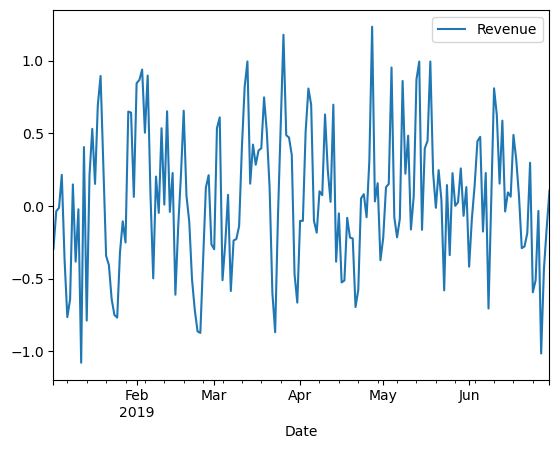

In [48]:
#Look for seasonality in data
df_stationary.loc[:'2019-06-30'].plot();

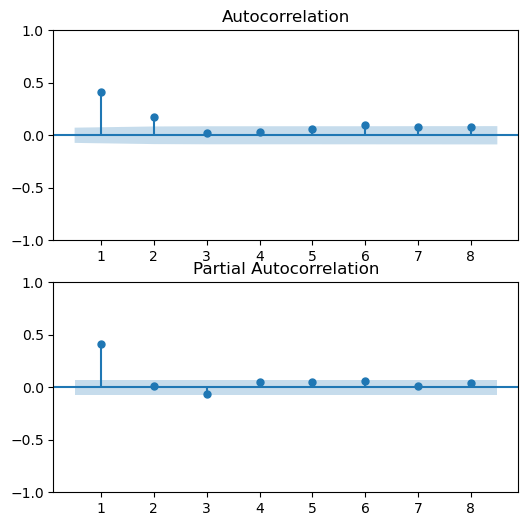

In [50]:
#ACF and PACF Autocorrelation Plots
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(6,6))
#ACF
plot_acf(df_stationary, lags=8, zero=False, ax=ax1)
#PACF
plot_pacf(df_stationary, lags=8, zero=False, ax=ax2)
plt.show();

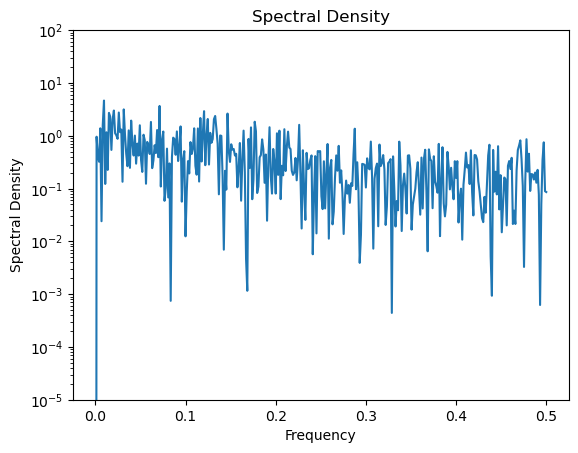

In [52]:
#Spectral Density
f, Pxx_den=signal.periodogram(df_stationary['Revenue'])
plt.semilogy(f,Pxx_den)
plt.ylim([1e-5,1e2])
plt.title('Spectral Density')
plt.xlabel('Frequency')
plt.ylabel('Spectral Density')
plt.show()

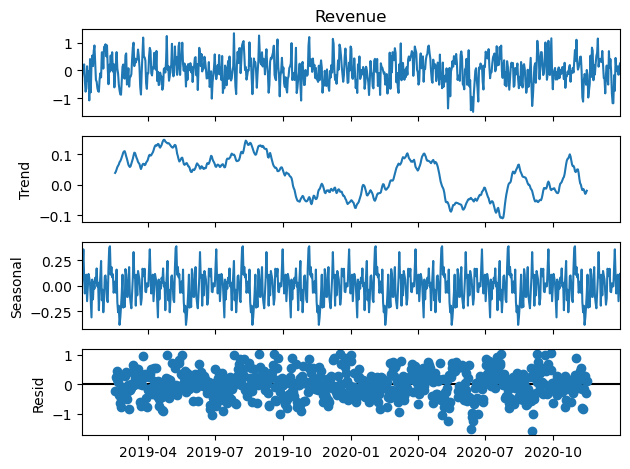

In [54]:
#Decomposition
decomp = seasonal_decompose(df_stationary['Revenue'],period=90)

decomp.plot()
plt.show()

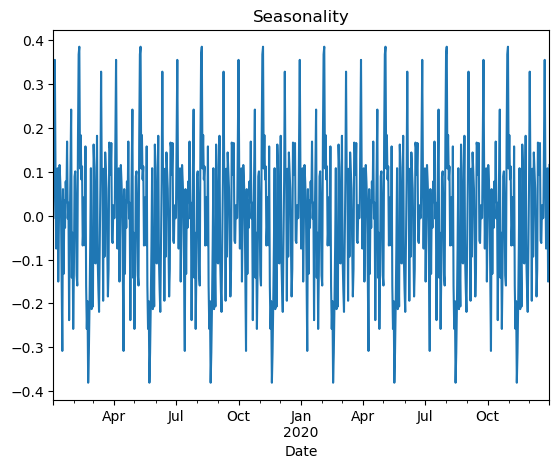

In [56]:
#Seasonality
plt.title('Seasonality')
decomp.seasonal.plot();

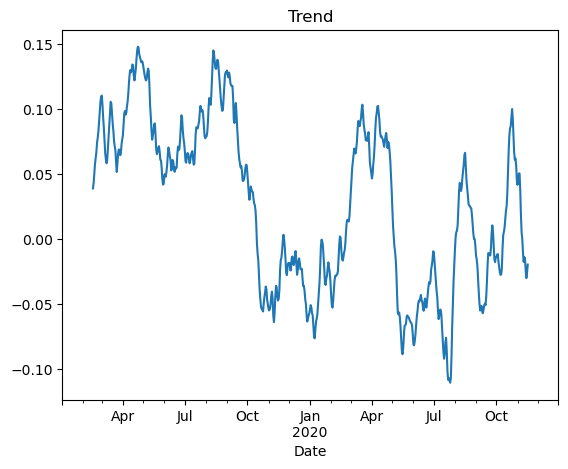

In [58]:
#Trend
plt.title('Trend')
decomp.trend.plot();

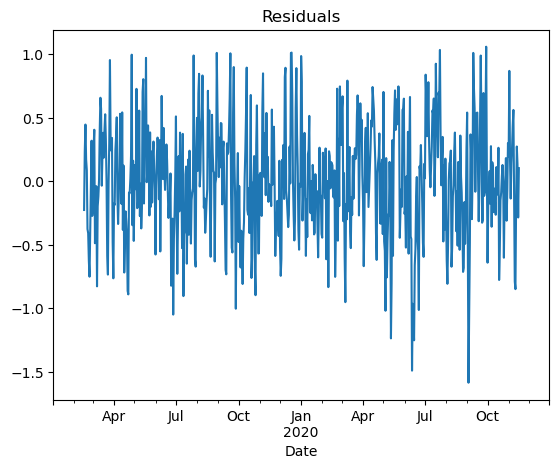

In [60]:
#Residual
plt.title('Residuals')
decomp.resid.plot();

**D.2.  Identify an autoregressive integrated moving average (ARIMA) model that accounts for the observed trend and seasonality of the time series data.**

We used auto ARIMA (see screenshot below for code and output) to find the best model for the dataset. This tries fitting multiple ARIMA models, gives us a printout of all possible versions, and searches for the model with the lowest AIC value. For this dataset, auto ARIMA found the model with a p = 1, d = 0, and q = 0 to have the lowest AIC of 879.982. This model had a low p-value of 0.00; therefore, the first lag has a strong relationship with time. The Ljung-Box test indicates the autocorrelation between the residuals and noise. A 0.02 Ljung-Box test result shows that the residuals of the ARIMA model have no significant autocorrelation and are due to white noise. Autocorrelation also means that the ARIMA model is not a perfect fit for our time series. Because of that, the model may miss some relationships in the dataset. However, the chosen model (1, 0, 0) is suitable for forecasting.

In [62]:
#ARIMA model using auto_arima
from pmdarima import auto_arima
stepwise_fit=auto_arima(df_stationary['Revenue'], trace=True, suppress_warnings=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=883.277, Time=0.46 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1015.972, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=881.359, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=906.199, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1015.481, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=883.300, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=883.314, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=883.348, Time=0.26 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=879.982, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=881.911, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=881.927, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=905.166, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=881.947, Time=0.12 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0]          
Total fit time: 1.373 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  730
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -437.991
Date:                Sat, 04 Jan 2025   AIC                            879.982
Time:                        17:23:51   BIC                            889.168
Sample:                    01-02-2019   HQIC                           883.526
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4142      0.034     12.258      0.000       0.348       0.480
sigma2         0.1943      0.011     17.842      0.000       0.173       0.216
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 1.92
Prob(Q):                              0.90   Prob(JB):                         0.38
Heteroskedasticity (H):               1.00   Skew:                            -0.02
Prob(H) (two-sided):                  0.97   Kurtosis:                         2.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**D.3.  Perform a forecast using the derived ARIMA model identified in part D2.**

In [64]:
#Time Series Model -- Using p, d, q values from the auto_arima results -- (ARIMA(1,0,0))
model = ARIMA(df_stationary, order=(1, 0, 0), freq='D')
results = model.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                Revenue   No. Observations:                  730
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -437.680
Date:                Sat, 04 Jan 2025   AIC                            881.359
Time:                        17:23:51   BIC                            895.139
Sample:                    01-02-2019   HQIC                           886.675
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0219      0.028      0.789      0.430      -0.033       0.076
ar.L1          0.4130      0.034     12.218      0.000       0.347       0.479
sigma2         0.1942      0.011     17.851      0.0

/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


**D.4.  Provide the output and calculations of the analysis you performed.** 
Mean Absolute Error (MAE) indicates the performance of the model and its ability to forecast. The lower the MAE, the better the model's ability to predict. Our model had a relatively small MAE; therefore, it will provide reasonably accurate revenue predictions.  

Standardized Residuals plot indicates that the residuals fluctuate randomly and have no apparent pattern. This means that the model fits the time series data well. The histogram plus estimated density plot visually demonstrates a normal distribution, and the KDE line is close to the normal distribution line, which supports normality for the residuals. The normal Q-Q plot confirms that the residuals (blue data points) align with a normal distribution (red line). For this model, the data points surround the red line, confirming the model's residuals do follow a normal distribution. The Correlogram (ACF) plot shows the correlation between residuals at specific lags. For this model, the autocorrelations are all within the blue shaded region: confidence intervals. This suggests no significant autocorrelation in the residuals and indicates that the model fits well with the data's time dependence.

In [66]:
#Print mean absolute error
mae = np.mean(np.abs(results.resid))
print("Mean Absolute Error: ", mae)

Mean Absolute Error:  0.3559307416455106


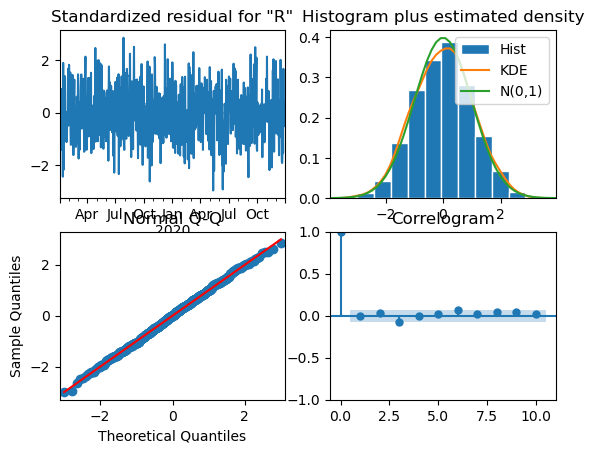

In [68]:
#Create the 4 diagnostics plots
results.plot_diagnostics().show()

**D.5.  Provide the code used to support the implementation of the time series model.**

See files attached in task submission. 

**Part V: Data Summary and Implications** 

**E.1. Discuss the results of your data analysis, including the following points:**
**- the selection of an ARIMA model**
The ARIMA model (1, 0, 0) was chosen based on stationarity, model order, and diagnostic plots. The data's stationarity was determined by using the augmented Dicky Fuller test and the p-value. Both tests concluded that the dataset was stationary and had a p-value of less than 0.05. The model order (AR=1) was chosen over a moving average term as the auto ARIMA code outputs an autoregressive suggestion. The AR model had the lowest AIC value and confirmed that the model would fit the data's structure well. The plots and statistical tests completed after running the model further confirmed how well the model fits the dataset and how well the model would predict a forecast. Those statistical tests confirmed that the model's residuals were normally distributed, uncorrelated, and had a constant variance. 

**- the prediction interval of the forecast**
Based on the research question, forecasting the next quarter's revenue (90 days), the prediction interval used was 90 days. This is 90 days after the last 'step' or date in the training/testing datasets.   

**- a justification of the forecast length**
Again, 90 days (steps) was chosen as the prediction interval because the research question was to predict or forecast the hospital's next quarter revenue.

**- the model evaluation procedure and error metric**
Residual tests were conducted to evaluate the model's fit to the data. The results indicated no autocorrelation. The residuals were normally distributed and showed a constant variance. These suggested that the model was a good fit for the data. The Ljung-Box test results were 0.93, which confirms that the residuals are uncorrelated.  

Mean Absolute Error (MAE) was completed to measure the model's prediction accuracy. The lower the number for MAE, the better the model's prediction accuracy. For our model, MAE was approximately 0.36; this is very low (near 0) and indicates the model's predictions are relatively accurate. In addition to MAE, the AIC value helped choose a model (with the lowest AIC) compared to the others computed from auto ARIMA.

**E.2. Provide an annotated visualization of the forecast of the final model compared to the test set.**
The forecast (screenshot below) follows the observed revenue in the test dataset. However, there is a delay in when (different dates) the revenue changes will occur with the model.

In [103]:
#Validate w/Test Set
#Predictions
prediction = results.get_prediction(start=-90)
#Prediction Mean
mean_prediction = prediction.predicted_mean
#Confidence Intervals
confidence_intervals = prediction.conf_int()
#Upper & lower conf limits
lower_limits = confidence_intervals.loc[:,'lower Revenue']
upper_limits = confidence_intervals.loc[:,'upper Revenue']
print(mean_prediction)

2020-10-03   -0.025548
2020-10-04    0.012247
2020-10-05    0.049621
2020-10-06   -0.122674
2020-10-07   -0.010534
                ...   
2020-12-27    0.038279
2020-12-28   -0.000635
2020-12-29    0.072243
2020-12-30   -0.051905
2020-12-31    0.059900
Freq: D, Name: predicted_mean, Length: 90, dtype: float64


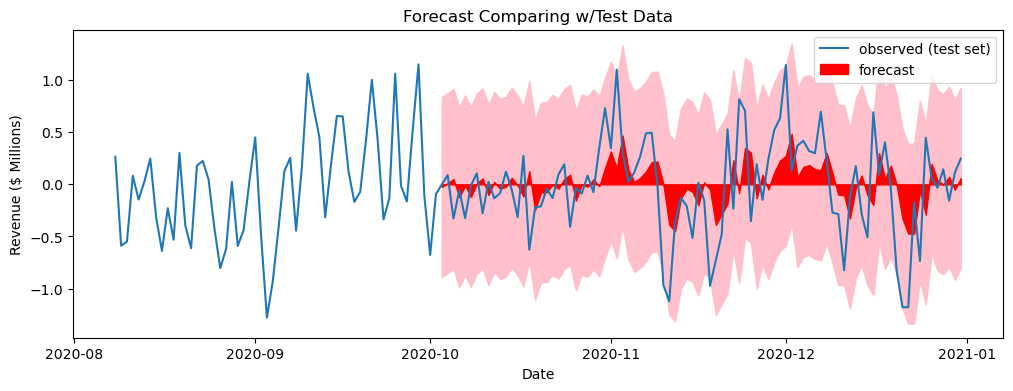

In [106]:
#Plot Data
plt.figure(figsize=(12,4))
plt.plot(np.array(test.index), np.array(test[['Revenue']]), label='observed (test set)')
#shade upper CI
plt.fill_between(upper_limits.index, upper_limits, lower_limits, color='pink')
#plot mean predictions
plt.fill_between(mean_prediction.index, mean_prediction, color='red', label='forecast')

plt.title('Forecast Comparing w/Test Data')
plt.xlabel('Date')
plt.ylabel('Revenue ($ Millions)')
plt.legend()
plt.show()

In [77]:
#Perform forecast
diff_forecast = results.get_forecast(steps=90)
mean_forecast = diff_forecast.predicted_mean
#Conf intervals of predictions
confidence_intervals = diff_forecast.conf_int()
#Upper & Lower conf limits
lower_limits = confidence_intervals.loc[:,'lower Revenue']
upper_limits = confidence_intervals.loc[:,'upper Revenue']

In [83]:
lower_limits.index

DatetimeIndex(['2021-01-01', '2021-01-02', '2021-01-03', '2021-01-04',
               '2021-01-05', '2021-01-06', '2021-01-07', '2021-01-08',
               '2021-01-09', '2021-01-10', '2021-01-11', '2021-01-12',
               '2021-01-13', '2021-01-14', '2021-01-15', '2021-01-16',
               '2021-01-17', '2021-01-18', '2021-01-19', '2021-01-20',
               '2021-01-21', '2021-01-22', '2021-01-23', '2021-01-24',
               '2021-01-25', '2021-01-26', '2021-01-27', '2021-01-28',
               '2021-01-29', '2021-01-30', '2021-01-31', '2021-02-01',
               '2021-02-02', '2021-02-03', '2021-02-04', '2021-02-05',
               '2021-02-06', '2021-02-07', '2021-02-08', '2021-02-09',
               '2021-02-10', '2021-02-11', '2021-02-12', '2021-02-13',
               '2021-02-14', '2021-02-15', '2021-02-16', '2021-02-17',
               '2021-02-18', '2021-02-19', '2021-02-20', '2021-02-21',
               '2021-02-22', '2021-02-23', '2021-02-24', '2021-02-25',
      

In [114]:
mean_forecast

2021-01-01    0.114697
2021-01-02    0.060237
2021-01-03    0.037745
2021-01-04    0.028456
2021-01-05    0.024620
                ...   
2021-03-27    0.021920
2021-03-28    0.021920
2021-03-29    0.021920
2021-03-30    0.021920
2021-03-31    0.021920
Freq: D, Name: predicted_mean, Length: 90, dtype: float64

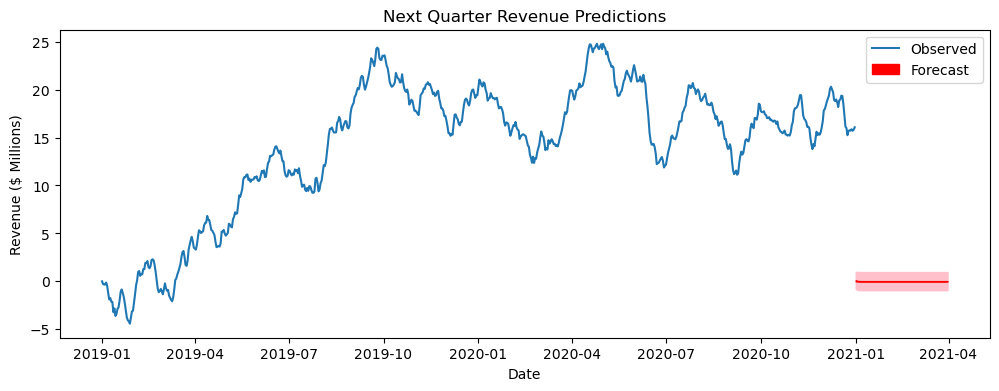

In [95]:
#Plot Data
plt.figure(figsize=(12,4))
plt.plot(df.index, df, label= 'Observed')
#shade upper CI
plt.fill_between(upper_limits.index, upper_limits, lower_limits, color='pink')
#plot mean predictions
plt.fill_between(mean_forecast.index, mean_forecast, color='red', label='Forecast')

plt.title('Next Quarter Revenue Predictions')
plt.xlabel('Date')
plt.ylabel('Revenue ($ Millions)')
plt.legend()
plt.show()

<Axes: title={'center': 'Revenue projections for Next Quarter'}, xlabel='Date', ylabel='Revenue (in Millions)'>

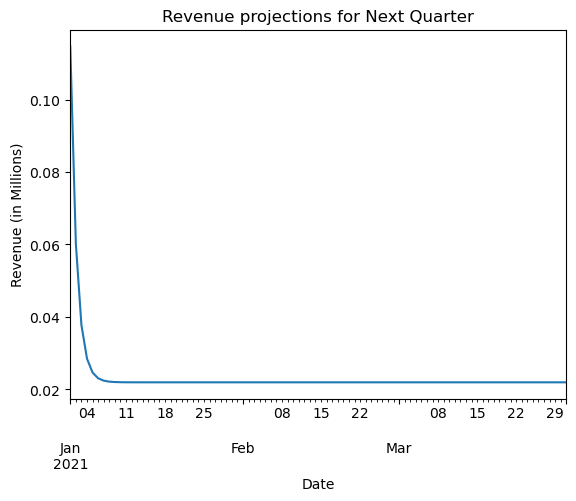

In [117]:
plt.title('Revenue projections for Next Quarter')
plt.xlabel('Date')
plt.ylabel('Revenue (in Millions)')
mean_forecast.plot()

**E.3.  Recommend a course of action based on your results.** 
Based on the forecasted quarter revenue results, the company should continue to monitor and forecast revenue for short-term forecasts. This will help the business identify quarters with potential revenue decline and take a proactive measure(s) to boost revenue. While monitoring the changes in revenue, the hospital can test how external factors, for example, staffing, services provided, or hours of operation, directly change the amount of revenue gained or lost during that period. The more data gathered (more than 2 years that was provided) would further enhance the insights provided and improve the model's predictability.

**Part VI: Reporting** 

**F. Code Document** 
See files attached in task submission. 

**G. Sources**
DataCamp. (2024). The best of the best models. Retrieved December 29, 2024, from https://campus.datacamp.com/courses/arima-models-in-python/the-best-of-the-best-models?learningMode=course&ex=1  

GeeksforGeeks. (July 05, 2022). Plot the power spectral density using Matplotlib – Python. Retrieved December 29, 2024, from https://www.geeksforgeeks.org/plot-the-power-spectral-density-using-matplotlib-python/  

Sewell, William. (2024). Time Series Analysis [PowerPoint slides]. WGU. https://westerngovernorsuniversity-my.sharepoint.com/:p:/g/personal/william_sewell_wgu_edu/EZXf-NityGNLhehsXVZLyZYBd3bBpEuAh-W71wZJnLcEyA?e=Lu16z9 

Stack Overflow. (n.d.). Converting day count to date time. Retrieved December 29, 2024, from https://stackoverflow.com/questions/61389654/converting-day-count-to-date-time 

Stack Overflow. (n.d.). Add trendline for time series graph. Retrieved December 29, 2024, from https://stackoverflow.com/questions/61011711/add-trendline-for-timeseries-graph 